In [13]:
# Step 1: Import Necessary Libraries
import pandas as pd
import numpy as np
import re
import os

print("Libraries imported successfully.")


Libraries imported successfully.


In [8]:
# Step 2: Define File Paths
# We assume the notebook is in the 'notebooks' folder, so we go one level up '../'
RAW_DATA_DIR = '../data/raw/'
PROCESSED_DATA_DIR = '../data/processed/'

# Create the processed data directory if it doesn't exist
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)

# File names
file1 = 'budgetwise_finance_dataset.csv'
file2 = 'budgetwise_synthetic_dirty.csv'

In [9]:
# Step 3: Load the Datasets
try:
    df1 = pd.read_csv(os.path.join(RAW_DATA_DIR, file1))
    df2 = pd.read_csv(os.path.join(RAW_DATA_DIR, file2))
    print("Datasets loaded successfully.")
    print("Dataset 1 Shape:", df1.shape)
    print("Dataset 2 Shape:", df2.shape)
except FileNotFoundError as e:
    print(f"Error: {e}. Please make sure the datasets are in the 'data/raw/' directory.")
    # Exit or handle the error appropriately
    exit()

# Display initial info to understand the data
print("\n--- Initial Info for Dataset 1 ---")
df1.info()
print(df1.head())

print("\n--- Initial Info for Dataset 2 ---")
df2.info()
print(df2.head())

Datasets loaded successfully.
Dataset 1 Shape: (15900, 9)
Dataset 2 Shape: (15836, 9)

--- Initial Info for Dataset 1 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15900 entries, 0 to 15899
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   transaction_id    15900 non-null  object
 1   user_id           15900 non-null  object
 2   date              15414 non-null  object
 3   transaction_type  15900 non-null  object
 4   category          15615 non-null  object
 5   amount            15609 non-null  object
 6   payment_mode      15092 non-null  object
 7   location          14638 non-null  object
 8   notes             13079 non-null  object
dtypes: object(9)
memory usage: 559.1+ KB
  transaction_id user_id        date transaction_type       category amount  \
0          T4999    U018  2023-04-25          Expense       Educaton   3888   
1         T12828    U133  08/05/2022          Expense           

In [10]:
# Step 4: Define a Comprehensive Cleaning Function
def clean_transaction_data(df):
    """
    Cleans and preprocesses a transaction dataframe.
    - Standardizes column names
    - Cleans 'amount' column
    - Parses 'date' column
    - Cleans string columns
    - Standardizes 'category'
    """
    # Standardize column names (lowercase, no extra spaces)
    df.columns = df.columns.str.strip().str.lower()

    # --- Clean 'amount' column ---
    if df['amount'].dtype == 'object':
        # Remove currency symbols, commas, and whitespace, then convert to numeric
        df['amount'] = df['amount'].str.replace(r'[$,]', '', regex=True).str.strip()
        df['amount'] = pd.to_numeric(df['amount'], errors='coerce')

    # --- Clean 'date' column ---
    # pd.to_datetime can handle many formats automatically. 'coerce' turns errors into NaT (Not a Time)
    df['date'] = pd.to_datetime(df['date'], errors='coerce')

    # --- Clean string/categorical columns ---
    for col in ['transaction_type', 'category', 'payment_mode', 'location', 'notes']:
        if col in df.columns and df[col].dtype == 'object':
            df[col] = df[col].str.strip().str.lower()

    # --- Standardize Categories (example) ---
    # You can add more rules as you explore the data
    category_mapping = {
        'educaton': 'education'
    }
    if 'category' in df.columns:
        df['category'] = df['category'].replace(category_mapping)
        
    return df


In [11]:
# Step 5: Apply the Cleaning Function to Both DataFrames
print("\n--- Cleaning DataFrames ---")
df1_cleaned = clean_transaction_data(df1.copy())
df2_cleaned = clean_transaction_data(df2.copy())
print("Cleaning complete.")

# Step 6: Merge the Cleaned DataFrames
print("\n--- Merging DataFrames ---")
df_merged = pd.concat([df1_cleaned, df2_cleaned], ignore_index=True)
print("Merge complete. Shape of merged data:", df_merged.shape)

# Step 7: Post-Merge Cleaning
# --- Handle Missing Values ---
print("\n--- Handling Missing Values ---")
print("Missing values before handling:")
print(df_merged.isnull().sum())

# Strategy for handling NaNs:
# amount: Drop rows where amount is missing, as it's critical.
df_merged.dropna(subset=['amount', 'date'], inplace=True)

# category, payment_mode, location: Fill with 'unknown'
for col in ['category', 'payment_mode', 'location', 'notes']:
    if col in df_merged.columns:
        df_merged[col].fillna('unknown', inplace=True)

print("\nMissing values after handling:")
print(df_merged.isnull().sum())


# --- Handle Duplicates ---
df_merged.drop_duplicates(inplace=True)
print(f"\nShape after dropping duplicates: {df_merged.shape}")


# Step 8: Final Feature Creation & Sorting
# Create time-based features from the 'date' column
df_merged['year'] = df_merged['date'].dt.year
df_merged['month'] = df_merged['date'].dt.month
df_merged['day'] = df_merged['date'].dt.day
df_merged['day_of_week'] = df_merged['date'].dt.dayofweek # Monday=0, Sunday=6

# Sort the dataframe by date
df_merged.sort_values(by='date', inplace=True)

# Reset index
df_merged.reset_index(drop=True, inplace=True)

print("\n--- Final Cleaned DataFrame ---")
df_merged.info()
print(df_merged.head())


# Step 9: Save the Processed Data
output_path = os.path.join(PROCESSED_DATA_DIR, 'cleaned_transactions.csv')
df_merged.to_csv(output_path, index=False)
print(f"\nProcessed data successfully saved to: {output_path}")



--- Cleaning DataFrames ---
Cleaning complete.

--- Merging DataFrames ---
Merge complete. Shape of merged data: (31736, 9)

--- Handling Missing Values ---
Missing values before handling:
transaction_id          0
user_id                 0
date                23295
transaction_type        0
category              443
amount               4759
payment_mode         1311
location             1984
notes                4355
dtype: int64


<ipython-input-11-09c17a41c211>:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged[col].fillna('unknown', inplace=True)



Missing values after handling:
transaction_id      0
user_id             0
date                0
transaction_type    0
category            0
amount              0
payment_mode        0
location            0
notes               0
dtype: int64

Shape after dropping duplicates: (6730, 9)

--- Final Cleaned DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6730 entries, 0 to 6729
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   transaction_id    6730 non-null   object        
 1   user_id           6730 non-null   object        
 2   date              6730 non-null   datetime64[ns]
 3   transaction_type  6730 non-null   object        
 4   category          6730 non-null   object        
 5   amount            6730 non-null   float64       
 6   payment_mode      6730 non-null   object        
 7   location          6730 non-null   object        
 8   notes             6730 non-n

In [17]:
# Install packages in a browser-based Jupyter environment (like JupyterLite)
import piplite
await piplite.install(['seaborn', 'plotly'])

Starting Exploratory Data Analysis...
Cleaned dataset loaded for EDA.
  transaction_id user_id       date transaction_type      category   amount  \
0         T06082    U073 2019-01-01           income         bonus  28500.0   
1         T06491    U176 2019-01-04          expense          food     39.0   
2         T02632    U090 2019-01-06          expense       savings   3791.0   
3         T00251    U028 2019-01-06          expense          rent   1166.0   
4         T05867    U067 2019-01-07          expense  enertainment    537.0   

    payment_mode   location                  notes  year  month  day  \
0           cash    lucknow             course fee  2019      1    1   
1           cash     jaipur                   gift  2019      1    4   
2            upi    kolkata   netflix subscription  2019      1    6   
3  bank transfer     mumbai  grocery shopping late  2019      1    6   
4           cash  ahmedabad                   gift  2019      1    7   

   day_of_week  
0    

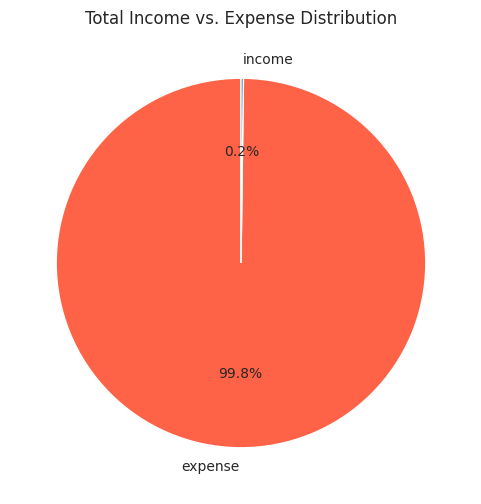


Analyzing Top 10 Expense Categories...


<ipython-input-19-318ba21e8857>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_expenses.index, y=top_10_expenses.values, palette='viridis')


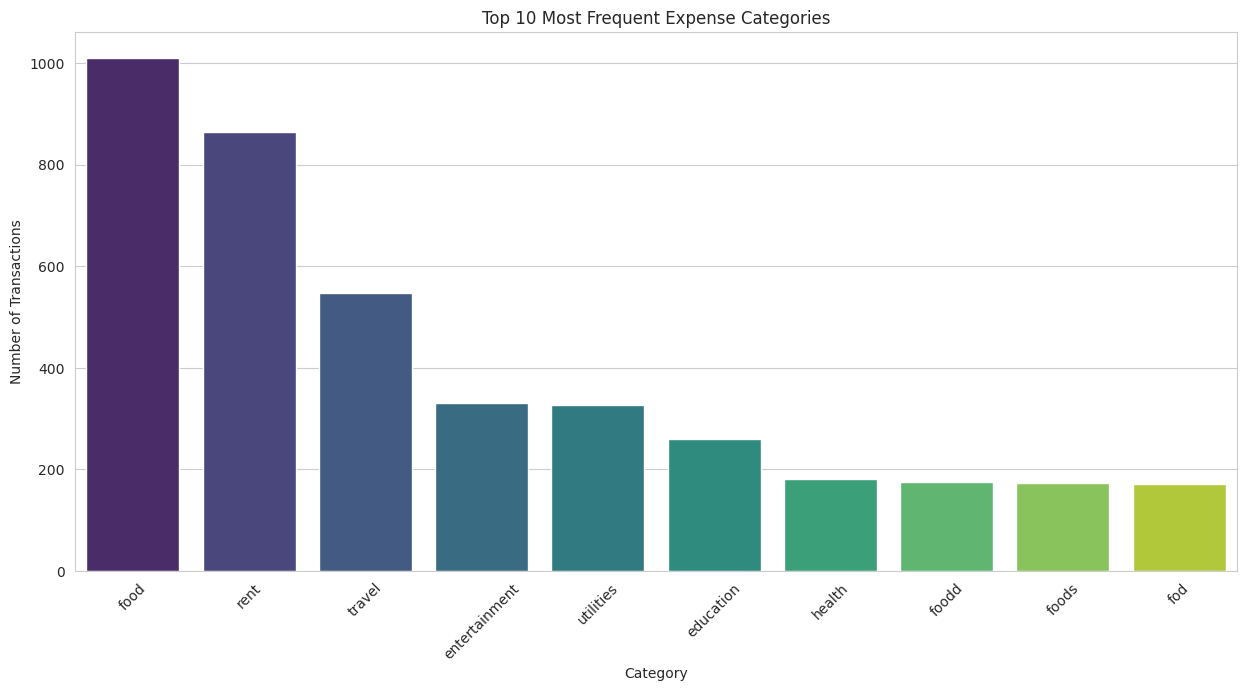


Analyzing Spending Over Time (Monthly)...


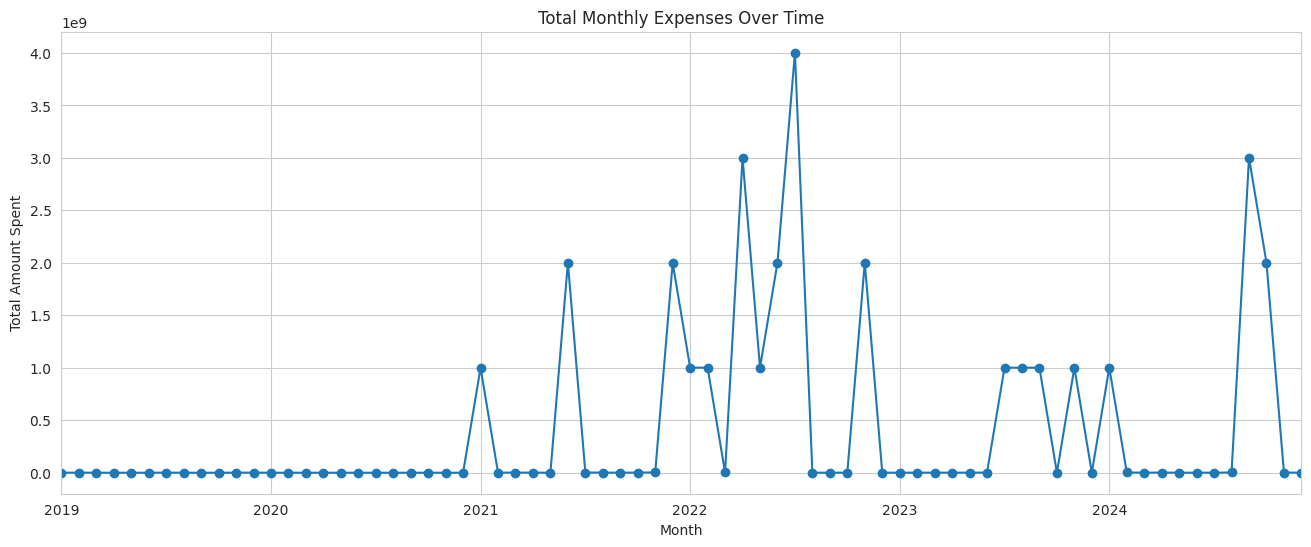


Analyzing Spending by Day of the Week...


<ipython-input-19-318ba21e8857>:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=daily_spending.index, y=daily_spending.values, palette='plasma')


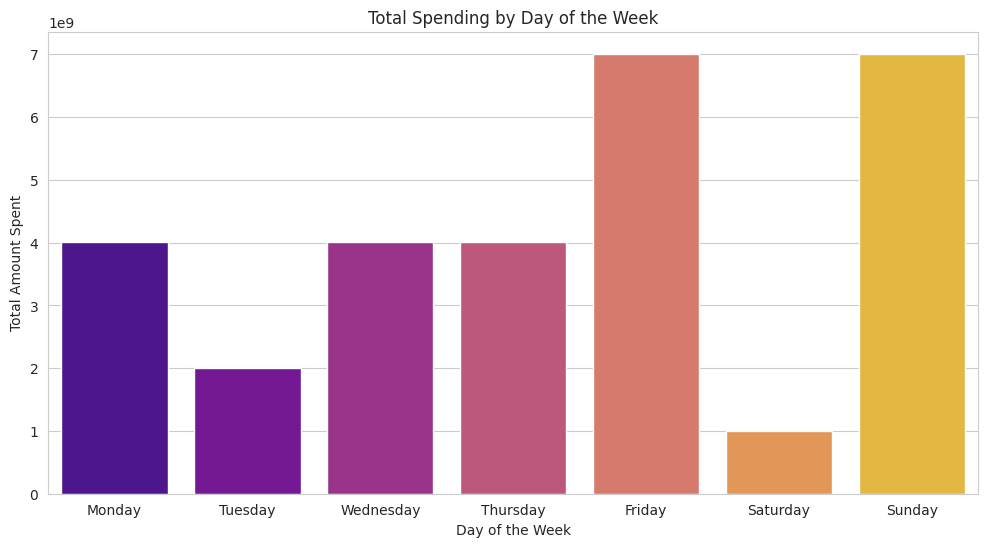


EDA complete. Review the charts above for insights.


In [19]:
# Step 10: Exploratory Data Analysis (EDA)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Set some plotting styles
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Starting Exploratory Data Analysis...")

# Load the cleaned dataset we just saved
df = pd.read_csv('../data/processed/cleaned_transactions.csv', parse_dates=['date'])
print("Cleaned dataset loaded for EDA.")
print(df.head())


# --- Analysis 1: Income vs. Expense ---
print("\nAnalyzing Income vs. Expense...")
income_vs_expense = df.groupby('transaction_type')['amount'].sum()

plt.figure(figsize=(6, 6))
income_vs_expense.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#ff6347', '#4682b4'])
plt.title('Total Income vs. Expense Distribution')
plt.ylabel('') # Hide the y-label
plt.show()


# --- Analysis 2: Top 10 Expense Categories ---
print("\nAnalyzing Top 10 Expense Categories...")
expense_df = df[df['transaction_type'] == 'expense']
top_10_expenses = expense_df['category'].value_counts().nlargest(10)

plt.figure(figsize=(15, 7))
sns.barplot(x=top_10_expenses.index, y=top_10_expenses.values, palette='viridis')
plt.title('Top 10 Most Frequent Expense Categories')
plt.xlabel('Category')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.show()


# --- Analysis 3: Spending Over Time (Monthly) [CORRECTED CODE] ---
print("\nAnalyzing Spending Over Time (Monthly)...")

# We work with the 'expense_df' which is already filtered for expenses.
# IMPORTANT: Set the 'date' column as the index for THIS DataFrame before resampling.
expense_df_indexed = expense_df.set_index('date')

# Resample to get the sum of expenses per month (using 'ME' for Month End as recommended by the warning)
monthly_expenses = expense_df_indexed.resample('ME')['amount'].sum()

plt.figure(figsize=(16, 6))
monthly_expenses.plot(kind='line', marker='o', linestyle='-')
plt.title('Total Monthly Expenses Over Time')
plt.xlabel('Month')
plt.ylabel('Total Amount Spent')
plt.grid(True) # Add a grid for better readability
plt.show()


# --- Analysis 4: Spending by Day of the Week ---
print("\nAnalyzing Spending by Day of the Week...")
day_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
expense_df_copy = expense_df.copy() # To avoid SettingWithCopyWarning
expense_df_copy['day_name'] = expense_df_copy['day_of_week'].map(day_map)

daily_spending = expense_df_copy.groupby('day_name')['amount'].sum().reindex(day_map.values())

plt.figure(figsize=(12, 6))
sns.barplot(x=daily_spending.index, y=daily_spending.values, palette='plasma')
plt.title('Total Spending by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Amount Spent')
plt.show()

print("\nEDA complete. Review the charts above for insights.")

# Reset index if you plan to use the dataframe further
df.reset_index(inplace=True)